对应 `tf.keras` 的01~02章节

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.9.0
numpy 1.26.4
pandas 2.2.2
sklearn 1.5.0
torch 2.3.1+cpu
cpu


In [1]:
28*28

784

## 数据准备

In [23]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms


# 定义数据集的变换
transform = transforms.Compose([
    transforms.ToTensor(), # 转换为tensor，进行归一化
    # transforms.Normalize(mean, std) # 标准化，mean和std是数据集的均值和方差
])
# fashion_mnist图像分类数据集，衣服分类，60000张训练图片，10000张测试图片
train_ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_ds = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分

In [24]:
type(train_ds)

torchvision.datasets.mnist.FashionMNIST

In [5]:
len(train_ds)

60000

In [8]:
type(train_ds[0])

tuple

In [25]:
# 通过id取数据，取到的是一个元祖,是第一个样本,在训练时，把特征和标签分开
img, label = train_ds[0]
img.shape
# img.shape = (1, 28, 28)，这是因为通道数在最前面

torch.Size([1, 28, 28])

In [18]:
img

In [22]:
type(img)

PIL.Image.Image

In [12]:
label

9

In [11]:
type(img) #tensor中文是 张量,和numpy的ndarray类似

torch.Tensor

In [8]:
label

9

In [19]:
# 显示图片，这里需要把transforms.ToTensor(),进行归一化注释掉，否则是不行的
def show_img_content(img):
    from PIL import Image

    # 打开一个图像文件
    # img = Image.open(img)


    print("图像大小:", img.size)
    print("图像模式:", img.mode)


    # 如果图像是单通道的，比如灰度图，你可以这样获取像素值列表：
    if img.mode == 'L':
        pixel_values = list(img.getdata())
        print(pixel_values)
show_img_content(img) #这里必须把上面的 transforms.ToTensor(), # 转换为tensor，进行归一化注释掉，否则是不行的

图像大小: (28, 28)
图像模式: L
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 13, 73, 0, 0, 1, 4, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 36, 136, 127, 62, 54, 0, 0, 0, 1, 3, 4, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 102, 204, 176, 134, 144, 123, 23, 0, 0, 0, 0, 12, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 155, 236, 207, 178, 107, 156, 161, 109, 64, 23, 77, 130, 72, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 69, 207, 223, 218, 216, 216, 163, 127, 121, 122, 146, 141, 88, 172, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 200, 232, 232, 233, 229, 223, 223, 215, 213, 164, 127, 123, 196, 229, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 183, 225, 216, 223, 228, 235, 227, 224, 222, 224, 221, 223, 245, 173, 0, 0, 0, 

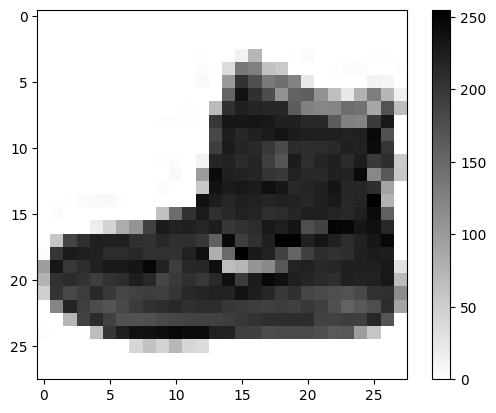

In [21]:
def show_single_image(img_arr):
    plt.imshow(img_arr, cmap="binary")
    plt.colorbar() # 显示颜色条
    plt.show()


show_single_image(img)

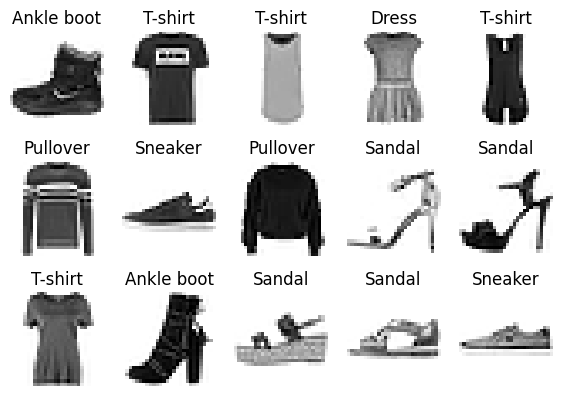

In [26]:
def show_imgs(n_rows, n_cols, train_ds, class_names):
    assert n_rows * n_cols < len(train_ds)  #确保打印的图片小于总样本数
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))  #宽1.4高1.6，宽，高
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col  # 计算索引，从0开始
            plt.subplot(n_rows, n_cols, index+1)#因为从1开始
            img_arr, label = train_ds[index]
            img_arr = np.transpose(img_arr, (1, 2, 0))  # 通道换到最后一维
            plt.imshow(img_arr, cmap="binary",
                       interpolation = 'nearest')
            plt.axis('off')#去除坐标系
            plt.title(class_names[label]) # 显示类别名称
    plt.show()
    
    

#已知的图片类别
# lables在这个路径https://github.com/zalandoresearch/fashion-mnist
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot'] #0-9分别代表的类别
#只是打印了前15个样本
show_imgs(3, 5, train_ds, class_names)


In [27]:
# 从数据集到dataloader
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True) #batch_size分批，shuffle洗牌
val_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

在PyTorch中，`DataLoader`是一个迭代器，它封装了数据的加载和预处理过程，使得在训练机器学习模型时可以方便地批量加载数据。`DataLoader`主要负责以下几个方面：

1. **批量加载数据**：`DataLoader`可以将数据集（Dataset）切分为更小的批次（batch），每次迭代提供一小批量数据，而不是单个数据点。这有助于模型学习数据中的统计依赖性，并且可以更高效地利用GPU等硬件的并行计算能力。

2. **数据打乱**：默认情况下，`DataLoader`会在每个epoch（训练周期）开始时打乱数据的顺序。这有助于模型训练时避免陷入局部最优解，并且可以提高模型的泛化能力。

3. **多线程数据加载**：`DataLoader`支持多线程（通过参数`num_workers`）来并行地加载数据，这可以显著减少训练过程中的等待时间，尤其是在处理大规模数据集时。

4. **数据预处理**：`DataLoader`可以与`transforms`结合使用，对加载的数据进行预处理，如归一化、标准化、数据增强等操作。

5. **内存管理**：`DataLoader`负责管理数据的内存使用，确保在训练过程中不会耗尽内存资源。

6. **易用性**：`DataLoader`提供了一个简单的接口，可以很容易地集成到训练循环中。



## 定义模型

In [29]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__() # 继承父类的初始化方法，子类有父类的属性
        self.flatten = nn.Flatten()  # 展平层
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 300),  # in_features=784, out_features=300, 784是输入特征数，300是输出特征数
            nn.ReLU(), # 激活函数
            nn.Linear(300, 100),#隐藏层神经元数100
            nn.ReLU(), # 激活函数
            nn.Linear(100, 10),#输出层神经元数10
        )

    def forward(self, x): # 前向计算
        # x.shape [batch size, 1, 28, 28]
        x = self.flatten(x)  
        # 展平后 x.shape [batch size, 784]
        logits = self.linear_relu_stack(x)
        # logits.shape [batch size, 10]
        return logits #没有经过softmax,称为logits
    
model = NeuralNetwork()

In [30]:
# 看看网络结构
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [31]:
784*300+300+300*100+100+100*10+10

266610

In [36]:
for name, param in model.named_parameters(): # 打印模型参数
      print(name, param.shape)

linear_relu_stack.0.weight torch.Size([300, 784])
linear_relu_stack.0.bias torch.Size([300])
linear_relu_stack.2.weight torch.Size([100, 300])
linear_relu_stack.2.bias torch.Size([100])
linear_relu_stack.4.weight torch.Size([10, 100])
linear_relu_stack.4.bias torch.Size([10])


In [33]:
# 看看模型参数
list(model.parameters())  # 这种方法拿到模型的所有可学习参数


[Parameter containing:
 tensor([[ 0.0244, -0.0103,  0.0082,  ..., -0.0189, -0.0207, -0.0055],
         [-0.0157,  0.0273,  0.0285,  ..., -0.0305, -0.0038, -0.0050],
         [ 0.0010, -0.0059, -0.0177,  ...,  0.0045,  0.0180,  0.0116],
         ...,
         [-0.0008,  0.0026, -0.0352,  ...,  0.0063, -0.0056, -0.0206],
         [-0.0343, -0.0348, -0.0285,  ...,  0.0309, -0.0049, -0.0144],
         [ 0.0301,  0.0304, -0.0242,  ..., -0.0272,  0.0053, -0.0128]],
        requires_grad=True),
 Parameter containing:
 tensor([-1.8328e-02, -3.1526e-02, -3.0268e-02,  2.9007e-03,  3.9361e-03,
         -1.3549e-02,  2.4452e-02,  1.2263e-03,  1.0421e-02, -2.2841e-02,
          2.7069e-02,  1.9943e-02, -3.2683e-02,  1.7253e-02,  5.7567e-03,
         -3.3080e-03, -1.6006e-02,  8.1032e-03, -1.1753e-02,  3.0903e-02,
          2.1283e-02,  1.5586e-02, -7.3822e-03, -9.2989e-03,  3.3226e-02,
         -1.5930e-02,  9.7400e-04,  2.4243e-02, -1.2498e-02, -1.3538e-02,
         -1.6537e-02, -3.1175e-02,  1.31

In [11]:
# model.state_dict()  # 这种方法用于保存模型参数，看能看见参数属于模型的哪一部分

OrderedDict([('linear_relu_stack.0.weight',
              tensor([[-0.0055,  0.0163,  0.0124,  ...,  0.0319, -0.0203,  0.0269],
                      [ 0.0153, -0.0245, -0.0317,  ...,  0.0341,  0.0107,  0.0069],
                      [ 0.0111, -0.0310,  0.0023,  ..., -0.0034,  0.0258, -0.0024],
                      ...,
                      [ 0.0322, -0.0073,  0.0338,  ...,  0.0129, -0.0088,  0.0320],
                      [-0.0149,  0.0097, -0.0005,  ..., -0.0276,  0.0196, -0.0067],
                      [-0.0230, -0.0082, -0.0256,  ..., -0.0331,  0.0186, -0.0220]])),
             ('linear_relu_stack.0.bias',
              tensor([ 4.3864e-03, -2.6291e-02, -3.0225e-02,  2.7419e-02, -2.3322e-03,
                       1.3853e-02,  1.9464e-02,  1.1548e-02,  2.6581e-02, -3.1549e-03,
                      -3.3493e-02,  2.3775e-02,  1.1570e-02,  3.0609e-02,  3.5390e-02,
                       6.3814e-03, -7.0325e-03, -2.3606e-02, -2.2584e-02, -2.2696e-02,
                      -1.3225e-0

## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [39]:
# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss() #内部先做softmax，然后计算交叉熵
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package,随机梯度下降
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [37]:
from sklearn.metrics import accuracy_score

@torch.no_grad() # 装饰器，禁止反向传播，节省内存
def evaluating(model, dataloader, loss_fct):
    loss_list = [] # 记录损失
    pred_list = [] # 记录预测
    label_list = [] # 记录标签
    for datas, labels in dataloader:#10000/32=312
        datas = datas.to(device) # 转到GPU
        labels = labels.to(device) # 转到GPU
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item()) # 记录损失
        
        preds = logits.argmax(axis=-1)    # 验证集预测,argmax返回最大值索引
        pred_list.extend(preds.cpu().numpy().tolist())#将PyTorch张量转换为NumPy数组。只有当张量在CPU上时，这个转换才是合法的
        # print(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
        
    acc = accuracy_score(label_list, pred_list) # 计算准确率
    return np.mean(loss_list), acc


In [12]:
1875*20

37500

In [40]:
# 训练
def training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=500):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar: # 进度条
        for epoch_id in range(epoch): # 训练epoch次
            # training
            for datas, labels in train_loader: #执行次数是60000/32=1875
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传，loss.backward()会计算梯度，loss对模型参数求导
                loss.backward()
                # 调整优化器，包括学习率的变动等,优化器的学习率会随着训练的进行而减小，更新w,b
                optimizer.step()

                preds = logits.argmax(axis=-1) # 训练集预测
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())   # 计算准确率，numpy可以
                loss = loss.cpu().item() # 损失转到CPU，item()取值
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                # udate step
                global_step += 1 # 全局步数加1
                pbar.update(1) # 更新进度条
                pbar.set_postfix({"epoch": epoch_id}) # 设置进度条显示信息
        
    return record_dict
        

epoch = 20
model = model.to(device)
record = training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=1000)

  0%|          | 0/37500 [00:00<?, ?it/s]

In [41]:
record

{'train': [{'loss': 2.298194646835327, 'acc': 0.0625, 'step': 0},
  {'loss': 2.3163394927978516, 'acc': 0.125, 'step': 1},
  {'loss': 2.3225150108337402, 'acc': 0.03125, 'step': 2},
  {'loss': 2.2887160778045654, 'acc': 0.15625, 'step': 3},
  {'loss': 2.294018030166626, 'acc': 0.0625, 'step': 4},
  {'loss': 2.3079729080200195, 'acc': 0.03125, 'step': 5},
  {'loss': 2.305385112762451, 'acc': 0.03125, 'step': 6},
  {'loss': 2.312462329864502, 'acc': 0.03125, 'step': 7},
  {'loss': 2.2872281074523926, 'acc': 0.09375, 'step': 8},
  {'loss': 2.295743703842163, 'acc': 0.09375, 'step': 9},
  {'loss': 2.3116488456726074, 'acc': 0.125, 'step': 10},
  {'loss': 2.306870460510254, 'acc': 0.125, 'step': 11},
  {'loss': 2.313328742980957, 'acc': 0.15625, 'step': 12},
  {'loss': 2.2925679683685303, 'acc': 0.09375, 'step': 13},
  {'loss': 2.3187193870544434, 'acc': 0.0625, 'step': 14},
  {'loss': 2.306962728500366, 'acc': 0.15625, 'step': 15},
  {'loss': 2.2995879650115967, 'acc': 0.09375, 'step': 16}

[2.29560494 0.81911939 0.5990057  0.40894181 0.50657839 0.48617503
 0.27716744 0.78045607 0.57754165 0.54340959 0.28681755 0.53811508
 0.76995969 0.46154392 0.25763142 0.4523966  0.33497784 0.26566157
 0.36665252 0.26281151 0.22449195 0.6174916  0.27716744 0.48265404
 0.2549125  0.2001891  0.36720216 0.15120862 0.4101848  0.29534885
 0.45695537 0.21770082 0.3058123  0.28563258 0.17859314 0.24384682
 0.30593064 0.14637847]


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

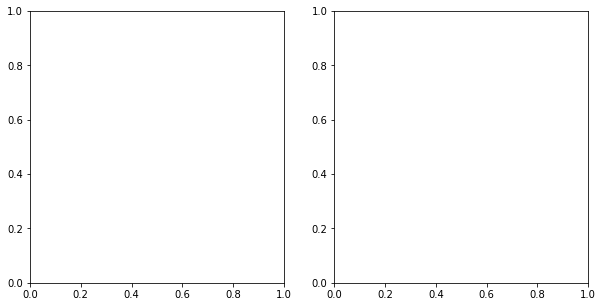

In [48]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=1000):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")
    last_step = train_df.index[-1]

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        print(train_df[item].values)
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, last_step, 5000)))
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves(record)  #横坐标是 steps

## 评估

In [ ]:
# dataload for evaluating

model.eval()
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")